In [9]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3

# Basic plots
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [10]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


# Training with Dask
Goals:
- Distributed Training

I will use a 2-stage workflow:
1. Load in and save data into user scratch or some other spot
2. Train model

In [41]:
# 1. Get EASI Defaults
easi = EasiDefaults()
bucket = easi.scratch

# 2. Get User ID
userid = boto3.client('sts').get_caller_identity()['UserId']

# 3. Define your Project Name and Dataset Name
project_name = "traning_test_project"
dataset_name = "training_dataset_v1.zarr"

# 4. Construct the full S3 Path
# This is where Dask will write the files
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"

#print(f"Target Storage Path: {s3_path}")

Successfully found configuration for deployment "csiro"


For stuff like loading in data, we don't need GPUs yet so this should be ok

In [42]:
gateway = Gateway()
options = gateway.cluster_options()

clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)


cluster.scale(4)
client = cluster.get_client()

#print("Cluster Dashboard:", client.dashboard_link)


Connecting to existing cluster: easihub.34d0e88747264547be95a49a2ab12fbd


In [43]:
# from datacube.utils.masking import describe_variable_flags

# # # Print the available flags for the fmask band
# # import pandas as pd

# # # Show all rows and columns
# # pd.set_option("display.max_rows", None)
# # pd.set_option("display.max_columns", None)
# # pd.set_option("display.width", None)
# # pd.set_option("display.max_colwidth", None)

# # # Now print the flags
# # describe_variable_flags(ds.fmask)
dc = datacube.Datacube()
# So workers can access AWS
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

In [58]:
# import numpy as np
# import pandas as pd
# from datacube.utils.aws import configure_s3_access

# print("🌤️ Hunting for clear skies in 2023 (Robust Mode)...")

# # 1. Configure S3 (Just in case)
# # We use the setting we found earlier (Private/Sydney usually works for definitive data)
# configure_s3_access(aws_unsigned=False, region_name='ap-southeast-2', requester_pays=True)

# # 2. Load fmask for the whole year
# ds_quality = dc.load(
#     product='ga_s2am_ard_3',
#     x=(149.0, 149.2),
#     y=(-35.4, -35.2),
#     time='2023',
#     measurements=['oa_fmask'], 
#     group_by='solar_day',
#     dask_chunks={'time': 1, 'x': 2048, 'y': 2048}
# )

# print(f"Found {len(ds_quality.time)} passes. Checking quality...")

# best_score = 0
# best_date = None

# # 3. Loop through days with Error Handling
# for t in range(len(ds_quality.time)):
#     try:
#         # Try to download the mask
#         mask = ds_quality.oa_fmask.isel(time=t).compute()
        
#         # If we get here, the file exists!
#         # 1=valid, 4=snow, 5=water
#         valid_pixels = np.count_nonzero(np.isin(mask, [1, 4, 5]))
#         total_pixels = mask.size
#         percentage = (valid_pixels / total_pixels) * 100
        
#         date_str = str(ds_quality.time[t].values).split('T')[0]
#         print(f"  📅 {date_str}: {percentage:.1f}% Clear")
        
#         if percentage > best_score:
#             best_score = percentage
#             best_date = date_str
            
#     except Exception:
#         # If the file is missing (404/403), just skip it
#         date_str = str(ds_quality.time[t].values).split('T')[0]
#         print(f"  ⚠️ {date_str}: File missing/stale. Skipping.")

# print("-" * 40)
# if best_date and best_score > 5.0:
#     print(f"✅ WINNER: {best_date} with {best_score:.1f}% clear view.")
#     print(f"👉 Update your 'time_range' variable to: '{best_date}'")
# else:
#     print("❌ No good data found. Try changing the year to '2022'.")

In [17]:
# Get the centroid of the coordinates of the default extents
central_lat = sum(easi.latitude)/2
central_lon = sum(easi.longitude)/2
# central_lat = -42.019
# central_lon = 146.615

# Set the buffer to load around the central coordinates
# This is a radial distance for the bbox to actual area so bbox 2x buffer in both dimensions
buffer = 0.8

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# Data product
products = easi.product('landsat')

# Set the date range to load data over
set_time = easi.time
set_time = (set_time[0], parse(set_time[0]) + relativedelta(years=1))
# set_time = ("2021-01-01", "2021-12-31")

# ------------------------ Measurment choice -----------------
# Selected measurement names (used in this notebook). None` will load all of them
alias = easi.aliases('landsat')
#all_measurements = list(alias.values())
#print(f"{alias.keys()}")

target_keys = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']


spectral_measurements = [alias[k] for k in target_keys]
#measurements = [alias['red'], alias['green'], alias['blue'], qa_band]
# measurements = [alias[x] for x in ['qa_band', 'red', 'nir']]

# Set the QA band name and mask values
qa_band = alias['qa_band']
qa_mask = easi.qa_mask('landsat')

measurements = spectral_measurements + [qa_band]

# Set the resampling method for the bands
resampling = {qa_band: "nearest", "*": "average"}

# Set the coordinate reference system and output resolution
set_crs = easi.crs('landsat')  # If defined, else None
set_resolution = easi.resolution('landsat')  # If defined, else None
# set_crs = "epsg:3577"
# set_resolution = (-30, 30)

# Set the scene group_by method
group_by = "solar_day"

In [32]:
from math import ceil

dataset = None # clear results from any previous runs
dataset = dc.load(
            product=products,
            x=study_area_lon,
            y=study_area_lat,
            time=set_time,
            measurements=measurements,
            resampling=resampling,
            output_crs=set_crs,
            resolution=set_resolution,
            dask_chunks = {"time":1, "x":2048, "y":2048},
            group_by=group_by,
        )
print(f"dataset size (GiB) {dataset.nbytes / 2**30:.2f}")
# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = masking.make_mask(dataset[qa_band], **qa_mask)
# Separate the bands we want to TRAIN on (RGB)
# Drop the QA band now, we don't feed it to the model.
training_ds = dataset[spectral_measurements]

# Apply Mask: Use , 0 to replace clouds with Black. 
# Default .where() creates NaNs, which break PyTorch.
ds_masked = training_ds.where(cloud_free_mask, 0)


# Landsat is Int16 (0-10,000). Normalize to Float32 (0-1).
ds_norm = ds_masked.astype('float32') / 10000.0

# Convert Dictionary (Dataset) to Block (DataArray)
# This stacks Red/Green/Blue into a new dimension 'band'
ds_final = ds_norm.to_array(dim='band')

#y_chunks = ceil(ds_final.dims['y']/10)
#x_chunks = ceil(ds_final.dims['x']/10)
# Rechunk for Training
ds_final = ds_final.chunk({'time': 1, 'x': 512, 'y': 512})

print("Data Pipeline Ready:")
ds_final

dataset size (GiB) 18.34
Data Pipeline Ready:


<xarray.DataArray (band: 6, time: 43, y: 6441, x: 5469)> Size: 36GB
dask.array<rechunk-merge, shape=(6, 43, 6441, 5469), dtype=float32, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 344B 2020-02-08T23:56:31.774346 ... 20...
  * y            (y) float64 52kB -3.922e+06 -3.922e+06 ... -4.115e+06
  * x            (x) float64 44kB 1.272e+06 1.272e+06 ... 1.436e+06 1.436e+06
    spatial_ref  int32 4B 3577
  * band         (band) object 48B 'nbart_blue' 'nbart_green' ... 'nbart_swir_2'
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [48]:
client.restart()

In [35]:
# Fixed an error in the Zar encoding, time already has units or something i guess?
ds_final.time.attrs.pop('units', None)

task = ds_final.to_zarr(s3_path, mode='w', consolidated=True, compute=False)

print("Graph built. Submitting to cluster...")

dask.compute(task)



/env/lib/python3.12/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Graph built. Submitting to cluster...


/env/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 37.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(None,)

In [36]:
# Check
ds = xr.open_dataset(s3_path, engine='zarr')
print(ds)

<xarray.Dataset> Size: 36GB
Dimensions:                        (band: 6, time: 43, y: 6441, x: 5469)
Coordinates:
  * band                           (band) object 48B 'nbart_blue' ... 'nbart_...
    spatial_ref                    int32 4B ...
  * time                           (time) datetime64[ns] 344B 2020-02-08T23:5...
  * x                              (x) float64 44kB 1.272e+06 ... 1.436e+06
  * y                              (y) float64 52kB -3.922e+06 ... -4.115e+06
Data variables:
    __xarray_dataarray_variable__  (band, time, y, x) float32 36GB ...


⏳ Verifying Saved Data (Automated Search)...
Checking Time 0... Cloudy/Empty. Skipping.
Checking Time 4... Valid Data Found! (Max: 0.72)


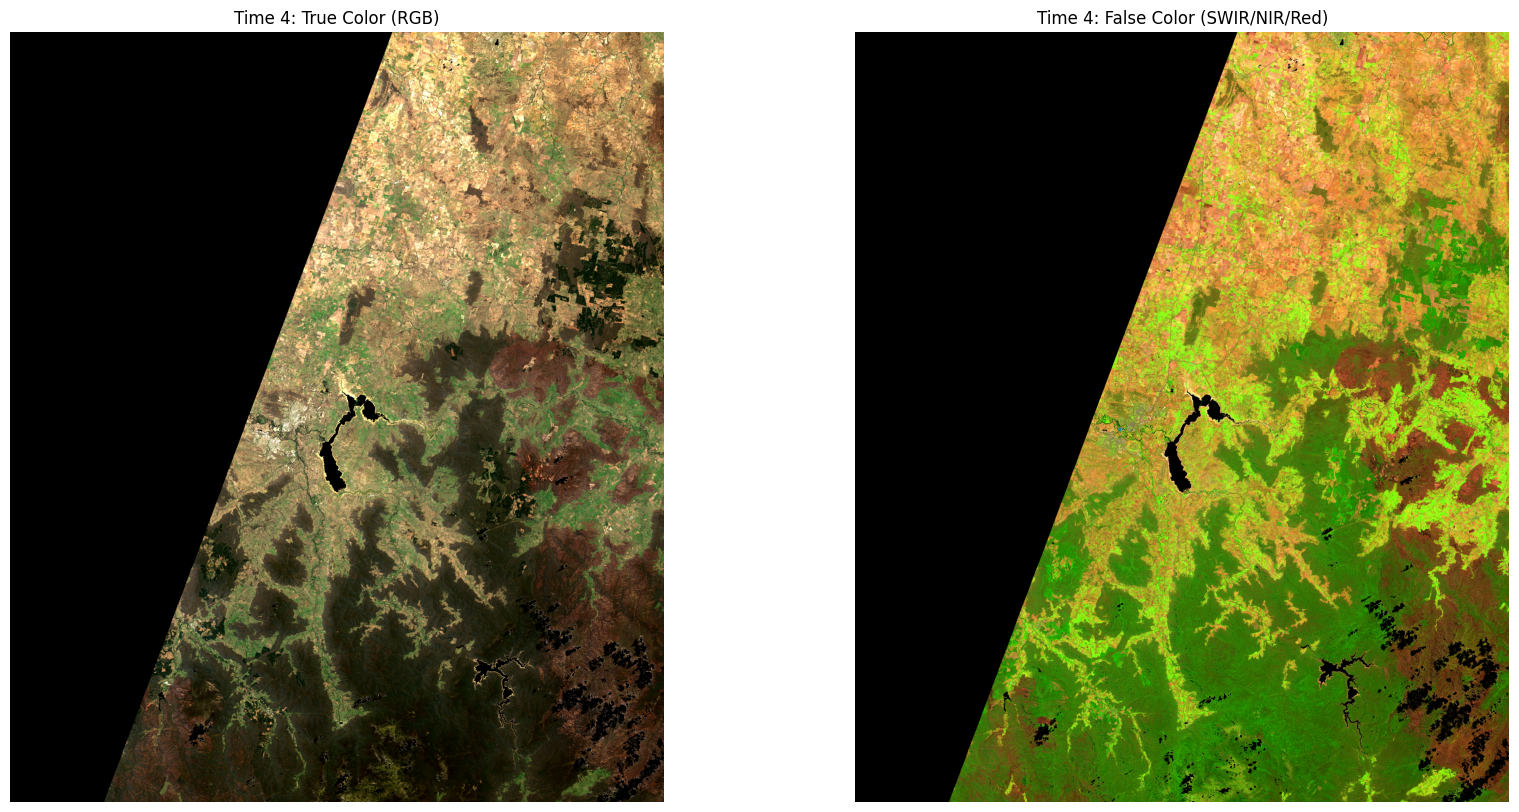

In [39]:
import xarray as xr
import s3fs
import numpy as np
import matplotlib.pyplot as plt

print("⏳ Verifying Saved Data (Automated Search)...")

# 1. Connect and Open
fs = s3fs.S3FileSystem(anon=False)
store = s3fs.S3Map(root=s3_path, s3=fs, check=False)
ds = xr.open_zarr(store, consolidated=True)
arr = ds['__xarray_dataarray_variable__']

# --- CONFIGURATION ---
# These match the keys you confirmed in the previous step
rgb_bands = ['nbart_red', 'nbart_green', 'nbart_blue']
false_color_bands = ['nbart_swir_1', 'nbart_nir', 'nbart_red'] # Fixed Name

# --- HELPER FUNCTION ---
def get_contrast_stretched_image(sample_block, band_names):
    """Extracts specific bands and applies robust contrast stretching."""
    try:
        # Select -> Transpose -> Numpy
        subset = sample_block.sel(band=band_names).transpose('y', 'x', 'band').values
        
        # Robust Scaling (2% - 98%)
        # This ignores shadows and bright clouds to show the land clearly
        valid_data = subset[subset > 0]
        if valid_data.size == 0: return subset # Return black if empty
        
        p_low, p_high = np.percentile(valid_data, (2, 98))
        
        # Avoid divide by zero if flat image
        if p_high == p_low: return subset
        
        img_stretched = (subset - p_low) / (p_high - p_low)
        return np.clip(img_stretched, 0, 1)
        
    except KeyError as e:
        print(f"❌ Band Name Error: {e}")
        return None

# --- THE SEARCH LOOP ---
found_image = False

# Check every 4th image to speed it up
for t in range(0, min(len(arr.time), 40), 4):
    print(f"Checking Time {t}...", end=" ")
    
    # Load just this time step
    sample = arr.isel(time=t).compute()
    
    # Check if it's empty/black (Max value check on Red band)
    if sample.sel(band=rgb_bands[0]).max() < 0.5:
        print("Cloudy/Empty. Skipping.")
        continue
        
    print(f"Valid Data Found! (Max: {sample.max().item():.2f})")
    
    # --- PLOTTING ---
    plt.figure(figsize=(20, 10))
    
    # 1. True Color
    plt.subplot(1, 2, 1)
    rgb_img = get_contrast_stretched_image(sample, rgb_bands)
    if rgb_img is not None:
        plt.imshow(rgb_img)
        plt.title(f"Time {t}: True Color (RGB)")
        plt.axis('off')
    
    # 2. False Color (Vegetation = Bright Green/Orange)
    plt.subplot(1, 2, 2)
    swir_img = get_contrast_stretched_image(sample, false_color_bands)
    if swir_img is not None:
        plt.imshow(swir_img)
        plt.title(f"Time {t}: False Color (SWIR/NIR/Red)")
        plt.axis('off')
    
    plt.show()
    
    found_image = True
    break # Stop after finding the first good one

if not found_image:
    print("\n❌ All checked images were cloudy. Consider changing dates in Data Prep.")

In [40]:
client.close()
cluster.shutdown()